**Chapter 13 – Convolutional Neural Networks**

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.12.0
2.2.4


_This notebook contains all the sample code and solutions to the exercices in chapter 13._

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 
# keras 或 tensorflow 调用GPU报错：Blas GEMM launch failed
# https://blog.csdn.net/Leo_Xu06/article/details/82023330
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config)) 

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [5]:
import tensorflow as tf

# Convolutional layer

# Then uninstall PIL and install Pillow

### conda uninstall PIL
### conda install Pillow

# Then in the provided code, replace

### from IPython.display import display, Image
### by

### from IPython.display import display
### from PIL import Image
### That's all. Re-run the code and it works without PIL error.

In [6]:
from IPython.display import display
from PIL import Image

In [7]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

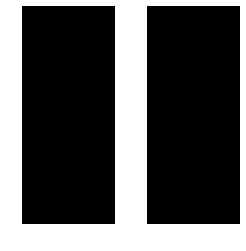

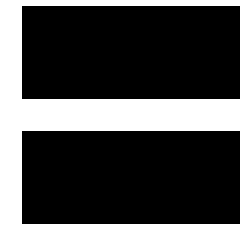

In [8]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [9]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=False)

In [10]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

UnimplementedError: Conv2D for GPU is not currently supported without cudnn
	 [[node Conv2D (defined at <ipython-input-9-bbb469930116>:5)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_0_0/_1, Const)]]

Caused by op 'Conv2D', defined at:
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-bbb469930116>", line 5, in <module>
    convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=False)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1044, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

UnimplementedError (see above for traceback): Conv2D for GPU is not currently supported without cudnn
	 [[node Conv2D (defined at <ipython-input-9-bbb469930116>:5)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_0_0/_1, Const)]]


Saving figure china_original


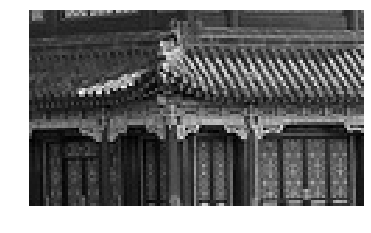

In [11]:
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

In [12]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

NameError: name 'output' is not defined

In [13]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

NameError: name 'output' is not defined

## Simple example

In [14]:
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D_1 (defined at <ipython-input-14-9c59d38ff7b7>:9)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_1_0_0/_1, Conv2D_1/filter)]]

Caused by op 'Conv2D_1', defined at:
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-9c59d38ff7b7>", line 9, in <module>
    convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1044, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D_1 (defined at <ipython-input-14-9c59d38ff7b7>:9)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_1_0_0/_1, Conv2D_1/filter)]]


## VALID vs SAME padding

In [ ]:
tf.reset_default_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

In [15]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:


NameError: name 'filter_primes' is not defined

# Pooling layer

Saving figure china_original


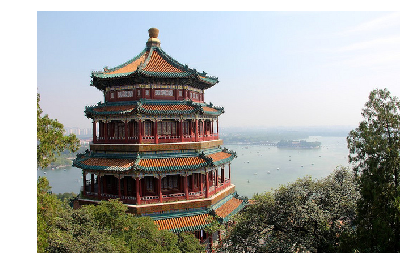

Saving figure china_max_pool


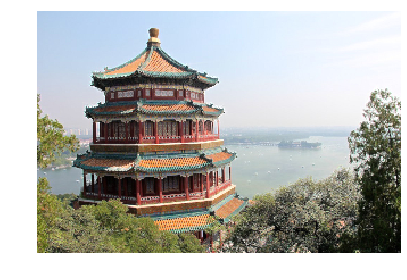

In [16]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plot_color_image(dataset[0])
save_fig("china_original")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.show()

# MNIST

In [17]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)
fetch_mnist()
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")

C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\lee\AppData\Local\conda\conda\envs\deep\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
# from six.moves import urllib
# from sklearn.datasets import fetch_mldata
# try:
#     mnist = fetch_mldata('MNIST original')
# except urllib.error.HTTPError as ex:
#     print("Could not download MNIST data from mldata.org, trying alternative...")

#     # Alternative method to load MNIST, if mldata.org is down
#     from scipy.io import loadmat
#     mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
#     mnist_path = "./mnist-original.mat"
#     response = urllib.request.urlopen(mnist_alternative_url)
#     with open(mnist_path, "wb") as f:
#         content = response.read()
#         f.write(content)
#     mnist_raw = loadmat(mnist_path)
#     mnist = {
#         "data": mnist_raw["data"].T,
#         "target": mnist_raw["label"][0],
#         "COL_NAMES": ["label", "data"],
#         "DESCR": "mldata.org dataset: mnist-original",
#     }
#     print("Success!")

In [19]:
X_train, X_test = mnist["data"][:60000].astype(np.float64), mnist["data"][60000:].astype(np.float64)
y_train, y_test = mnist["target"][:60000].astype(np.int64), mnist["target"][60000:].astype(np.int64)

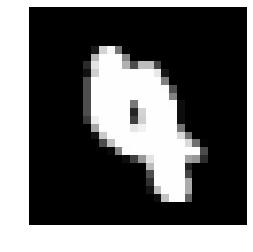

In [20]:
height, width = 28, 28
images = X_test[5000].reshape(1, height, width, 1)
plot_image(images[0, :, :, 0])

# Inception v3

In [21]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [22]:
fetch_pretrained_inception_v3()

In [23]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets","inception","imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [24]:
class_names = load_class_names()

In [25]:
width = 299
height = 299
channels = 3

In [26]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'images\\cnn\\test_image.png'

In [27]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

AttributeError: module 'dask.dataframe' has no attribute 'Series'

In [ ]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

In [ ]:
class_names[np.argmax(predictions_val[0])]

In [ ]:
np.argmax(predictions_val, axis=1)

In [ ]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = top_5[np.argsort(predictions_val[0][top_5])]
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100*predictions_val[0][i]))

# Exercise solutions

**Coming soon**